# Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.utils.data import DataLoader

import sys
import os

# Aggiunge la cartella principale del progetto al percorso di ricerca di Python
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importa dal nostro codice!
# Per farlo funzionare su Colab, dovrai prima caricare la cartella 'src'
from src.models import MLP, MLP_CIFAR
from src.aligners import PermutationAligner, OrthogonalAligner
from src.utils import get_datasets, train_model, evaluate_model, evaluate_interpolation, slerp_evaluate_interpolation, compare_predictions, calculate_logit_distance

# --- Configurazione ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


# Esperimento MNIST

## Addestramento

In [2]:
# --- Blocco 1: Setup Esperimento e Addestramento ---

# Impostazioni Esperimento
DATASET_NAME = 'MNIST'
MODEL_ARCH = MLP
EPOCHS = 3
BATCH_SIZE = 128
SEED_A = 42
SEED_B = 123

# 1. Caricamento Dati
print(f"--- Caricando il dataset {DATASET_NAME} ---")
train_dataset, test_dataset, _ = get_datasets(DATASET_NAME)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 2. Addestramento di Model A
print(f"\n--- Addestramento di Model A (seed={SEED_A}) ---")
torch.manual_seed(SEED_A)
model_a = MODEL_ARCH()
train_model(model_a, train_loader, DEVICE, EPOCHS)
sd_a = model_a.state_dict()
loss_a, acc_a = evaluate_model(model_a, test_loader, DEVICE)
print(f"Model A - Test Loss: {loss_a:.4f}, Test Accuracy: {acc_a:.2f}%")

# 3. Addestramento di Model B
print(f"\n--- Addestramento di Model B (seed={SEED_B}) ---")
torch.manual_seed(SEED_B)
model_b = MODEL_ARCH()
train_model(model_b, train_loader, DEVICE, epochs=EPOCHS)
sd_b = model_b.state_dict()
loss_b, acc_b = evaluate_model(model_b, test_loader, DEVICE)
print(f"Model B - Test Loss: {loss_b:.4f}, Test Accuracy: {acc_b:.2f}%")

print("\n--- Modelli A e B addestrati con successo ---")

--- Caricando il dataset MNIST ---

--- Addestramento di Model A (seed=42) ---


Epoch 3/3: 100%|██████████| 469/469 [00:08<00:00, 53.06it/s, loss=0.051, lr=0.00025]


Finished Training
Model A - Test Loss: 0.0706, Test Accuracy: 97.71%

--- Addestramento di Model B (seed=123) ---


Epoch 3/3: 100%|██████████| 469/469 [00:08<00:00, 55.31it/s, loss=0.055, lr=0.00025]


Finished Training
Model B - Test Loss: 0.0699, Test Accuracy: 97.75%

--- Modelli A e B addestrati con successo ---


## Allineamenti

In [3]:
# --- Esecuzione dell'Allineamento ---
print("\n--- Esecuzione degli allineamenti ---")

# 1. Allineamento con Permutazioni
permutation_aligner = PermutationAligner(MODEL_ARCH)
aligned_sd_b_perm = permutation_aligner.align(sd_a, sd_b)

# 2. Allineamento Ortogonale
orthogonal_aligner = OrthogonalAligner(MODEL_ARCH)
aligned_sd_b_orth = orthogonal_aligner.align(sd_a, sd_b)

print("\n--- Allineamenti completati ---")


--- Esecuzione degli allineamenti ---
Inizio allineamento con Permutazioni (Git Re-Basin)...
Convergenza raggiunta dopo 5 iterazioni.
Inizio allineamento con Matrici Ortogonali (Procrustes)...

--- Allineamenti completati ---


In [4]:
# --- Blocco 2.5: Quantificazione dell'Errore di Disallineamento Residuo ---

print("\n--- Quantificazione dell'Errore di Disallineamento Residuo ---")

# Creiamo istanze temporanee dei modelli per caricare gli state_dict allineati
aligned_model_perm = MODEL_ARCH().to(DEVICE)
aligned_model_perm.load_state_dict(aligned_sd_b_perm)

aligned_model_orth = MODEL_ARCH().to(DEVICE)
aligned_model_orth.load_state_dict(aligned_sd_b_orth)

# Recuperiamo l'accuratezza del model_b originale per riferimento
_, acc_b_original = evaluate_model(model_b, test_loader, DEVICE)

# Calcoliamo le metriche per l'allineamento a permutazione
_, acc_perm = evaluate_model(aligned_model_perm, test_loader, DEVICE)
agreement_perm = compare_predictions(model_b, aligned_model_perm, test_loader, DEVICE)
mse_perm = calculate_logit_distance(model_b, aligned_model_perm, test_loader, DEVICE)

# Calcoliamo le metriche per l'allineamento ortogonale
_, acc_orth = evaluate_model(aligned_model_orth, test_loader, DEVICE)
agreement_orth = compare_predictions(model_b, aligned_model_orth, test_loader, DEVICE)
mse_orth = calculate_logit_distance(model_b, aligned_model_orth, test_loader, DEVICE)


# Stampa dei risultati in una tabella chiara
print("\nConfronto della Funzionalità dopo l'Allineamento (vs. Model B originale)")
print("-" * 80)
print(f"{'Metodo di Allineamento':<25} | {'Accuratezza':>15} | {'Accordo Predizioni':>20} | {'MSE Logits':>12}")
print("-" * 80)
print(f"{'Originale (Model B)':<25} | {acc_b_original:>14.2f}% | {'100.00%':>19} | {'0.0':>12}")
print(f"{'Permutazione':<25} | {acc_perm:>14.2f}% | {agreement_perm:>19.2f}% | {mse_perm:>12.6f}")
print(f"{'Ortogonale (Procrustes)':<25} | {acc_orth:>14.2f}% | {agreement_orth:>19.2f}% | {mse_orth:>12.4f}")
print("-" * 80)

print("\nAnalisi:")
print("L'allineamento a permutazione preserva quasi perfettamente la funzione del modello (MSE vicino a zero, accordo ~100%).")
print("L'allineamento ortogonale introduce un significativo errore di disallineamento residuo,")
print("come dimostrato dal calo di accuratezza e dall'alto valore di MSE. Questo è l'effetto della non-commutatività con la ReLU.")


--- Quantificazione dell'Errore di Disallineamento Residuo ---

Confronto della Funzionalità dopo l'Allineamento (vs. Model B originale)
--------------------------------------------------------------------------------
Metodo di Allineamento    |     Accuratezza |   Accordo Predizioni |   MSE Logits
--------------------------------------------------------------------------------
Originale (Model B)       |          97.75% |             100.00% |          0.0
Permutazione              |          97.75% |              100.00% |     0.000000
Ortogonale (Procrustes)   |          95.74% |               97.04% |       2.4824
--------------------------------------------------------------------------------

Analisi:
L'allineamento a permutazione preserva quasi perfettamente la funzione del modello (MSE vicino a zero, accordo ~100%).
L'allineamento ortogonale introduce un significativo errore di disallineamento residuo,
come dimostrato dal calo di accuratezza e dall'alto valore di MSE. Questo è

# Graifici


--- Esecuzione delle interpolazioni ---

1. Interpolazione tra modelli NON allineati (Naive):


Evaluating LERP Interpolation: 100%|██████████| 21/21 [00:20<00:00,  1.02it/s, alpha=1.00, loss=0.070, acc=97.75%]



2. Interpolazione LERP tra modelli allineati con PERMUTAZIONI:


Evaluating LERP Interpolation: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it, alpha=1.00, loss=0.070, acc=97.75%]



3. Interpolazione LERP tra modelli allineati ORTOGONALMENTE:


Evaluating LERP Interpolation: 100%|██████████| 21/21 [00:46<00:00,  2.19s/it, alpha=1.00, loss=0.137, acc=95.74%]



4. Interpolazione SLERP tra modelli allineati con PERMUTAZIONI:


Evaluating SLERP Interpolation: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s, alpha=1.00, loss=0.070, acc=97.75%]



--- Generazione dei grafici ---


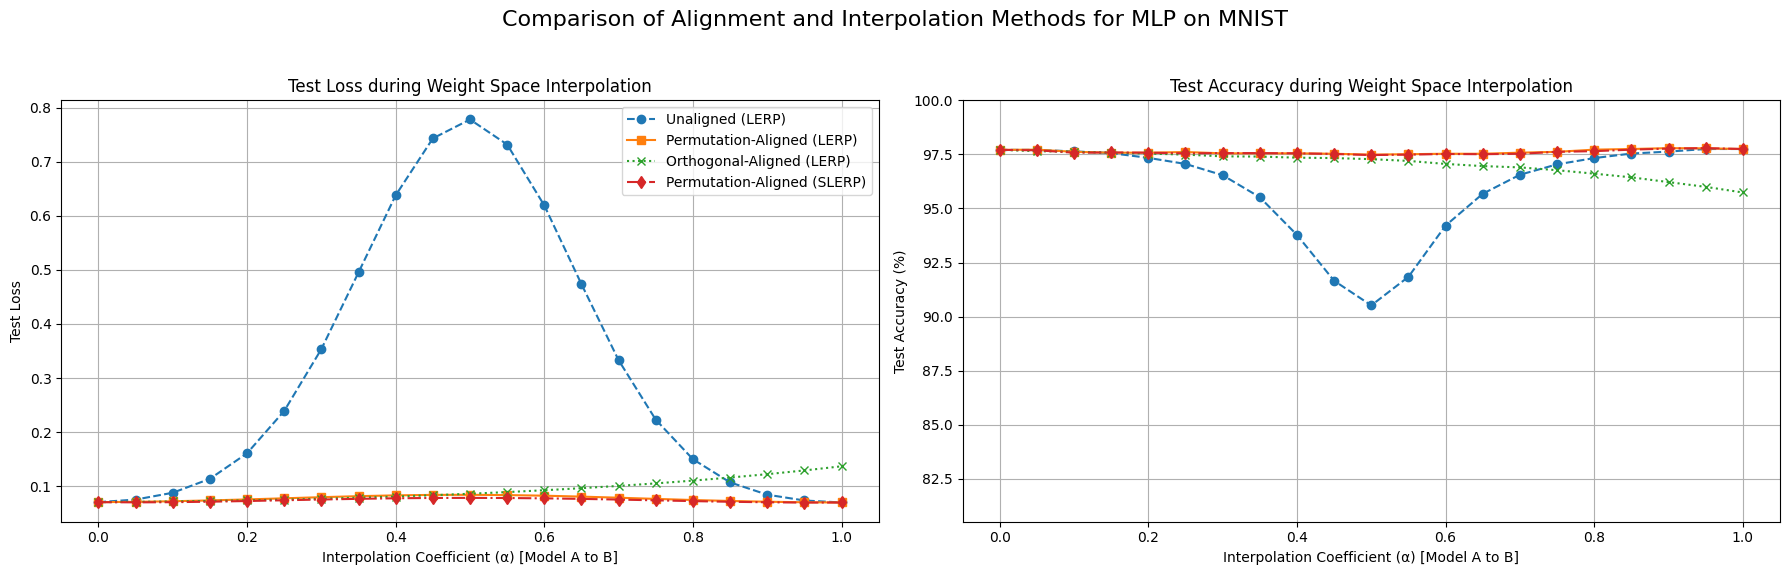

In [5]:
# 2. Esecuzione delle interpolazioni
print("\n--- Esecuzione delle interpolazioni ---")

# a) Non allineato (Naive LERP)
print("\n1. Interpolazione tra modelli NON allineati (Naive):")
alphas, losses_naive, accs_naive = evaluate_interpolation(MODEL_ARCH, sd_a, sd_b, test_loader, DEVICE)

# b) Allineato con Permutazioni (Git Re-Basin LERP)
print("\n2. Interpolazione LERP tra modelli allineati con PERMUTAZIONI:")
alphas, losses_perm, accs_perm = evaluate_interpolation(MODEL_ARCH, sd_a, aligned_sd_b_perm, test_loader, DEVICE)

# c) Allineato Ortogonalmente (Procrustes LERP)
print("\n3. Interpolazione LERP tra modelli allineati ORTOGONALMENTE:")
alphas, losses_orth, accs_orth = evaluate_interpolation(MODEL_ARCH, sd_a, aligned_sd_b_orth, test_loader, DEVICE)

# d) Allineato con Permutazioni (Git Re-Basin SLERP)
print("\n4. Interpolazione SLERP tra modelli allineati con PERMUTAZIONI:")
alphas, losses_slerp, accs_slerp = slerp_evaluate_interpolation(MODEL_ARCH, sd_a, aligned_sd_b_perm, test_loader, DEVICE)


# 3. Generazione dei grafici finali
print("\n--- Generazione dei grafici ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Grafico della Loss
ax1.plot(alphas, losses_naive, marker='o', linestyle='--', label='Unaligned (LERP)')
ax1.plot(alphas, losses_perm, marker='s', linestyle='-', label='Permutation-Aligned (LERP)')
ax1.plot(alphas, losses_orth, marker='x', linestyle=':', label='Orthogonal-Aligned (LERP)')
ax1.plot(alphas, losses_slerp, marker='d', linestyle='-.', label='Permutation-Aligned (SLERP)')
ax1.set_title('Test Loss during Weight Space Interpolation')
ax1.set_xlabel('Interpolation Coefficient (α) [Model A to B]')
ax1.set_ylabel('Test Loss')
ax1.grid(True)
ax1.legend()

# Grafico dell'Accuratezza
ax2.plot(alphas, accs_naive, marker='o', linestyle='--', label='Unaligned (LERP)')
ax2.plot(alphas, accs_perm, marker='s', linestyle='-', label='Permutation-Aligned (LERP)')
ax2.plot(alphas, accs_orth, marker='x', linestyle=':', label='Orthogonal-Aligned (LERP)')
ax2.plot(alphas, accs_slerp, marker='d', linestyle='-.', label='Permutation-Aligned (SLERP)')
ax2.set_title('Test Accuracy during Weight Space Interpolation')
ax2.set_xlabel('Interpolation Coefficient (α) [Model A to B]')
ax2.set_ylabel('Test Accuracy (%)')
ax2.grid(True)
# Imposta un limite inferiore per l'accuratezza per una migliore visualizzazione
min_acc = min(np.min(accs_naive), np.min(accs_orth), np.min(accs_perm), np.min(accs_slerp)) if len(accs_naive) > 0 else 10
ax2.set_ylim(bottom=max(0, min_acc - 10), top=100)


plt.suptitle('Comparison of Alignment and Interpolation Methods for MLP on MNIST', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
# --- Blocco 4: Test di Coerenza Ciclica (Cycle-Consistency) ---

print("\n--- Test di Coerenza Ciclica (Cycle-Consistency) ---")

# --- Test per OrthogonalAligner ---
orth_aligner_test = OrthogonalAligner(MODEL_ARCH)
# Calcola la trasformazione da A a B (allinea B a A)
_, Q_ab = orth_aligner_test.align(sd_a, sd_b, return_transformations=True)
# Calcola la trasformazione da B a A (allinea A a B)
_, Q_ba = orth_aligner_test.align(sd_b, sd_a, return_transformations=True)

# Verifichiamo per il primo layer
Q1_ab = Q_ab['layer1']
Q1_ba = Q_ba['layer1']
identity = torch.eye(Q1_ab.shape[0], device=DEVICE)
product = torch.matmul(Q1_ab, Q1_ba)
is_consistent_orth = torch.allclose(product, identity, atol=1e-5)
print(f"OrthogonalAligner è ciclicamente consistente? {is_consistent_orth}")
print(f"  Norma della differenza ||Q_ab @ Q_ba - I||: {torch.norm(product - identity).item():.6f}")

# --- Test per PermutationAligner ---
perm_aligner_test = PermutationAligner(MODEL_ARCH)
# Calcola la permutazione da A a B
_, P_ab_indices = perm_aligner_test.align(sd_a, sd_b, return_transformations=True)
# Calcola la permutazione da B a A
_, P_ba_indices = perm_aligner_test.align(sd_b, sd_a, return_transformations=True)

# Costruiamo le matrici di permutazione dal primo layer
P1_ab_idx = P_ab_indices['layer1']
P1_ba_idx = P_ba_indices['layer1']
size = len(P1_ab_idx)

# Verifichiamo la coerenza degli indici: P_ba(P_ab(i)) == i
reordered_indices = P1_ba_idx[P1_ab_idx]
is_consistent_perm_indices = torch.equal(reordered_indices, torch.arange(size, device=DEVICE))
print(f"PermutationAligner è ciclicamente consistente? {is_consistent_perm_indices}")

# Test opzionale con le matrici, che è equivalente
P1_ab = torch.eye(size, device=DEVICE)[P1_ab_idx]
P1_ba = torch.eye(size, device=DEVICE)[P1_ba_idx]
product_perm = torch.matmul(P1_ab, P1_ba)
is_consistent_perm_matrix = torch.allclose(product_perm, torch.eye(size, device=DEVICE))
print(f"  (Verifica con matrici): {is_consistent_perm_matrix}")


--- Test di Coerenza Ciclica (Cycle-Consistency) ---
Inizio allineamento con Matrici Ortogonali (Procrustes)...
Inizio allineamento con Matrici Ortogonali (Procrustes)...
OrthogonalAligner è ciclicamente consistente? False
  Norma della differenza ||Q_ab @ Q_ba - I||: 0.021892
Inizio allineamento con Permutazioni (Git Re-Basin)...
Convergenza raggiunta dopo 5 iterazioni.
Inizio allineamento con Permutazioni (Git Re-Basin)...
Convergenza raggiunta dopo 5 iterazioni.
PermutationAligner è ciclicamente consistente? True
  (Verifica con matrici): True


# Esperimento CIFAR10 MLP

--- Caricando il dataset CIFAR10 per l'MLP ---


100%|██████████| 170M/170M [00:27<00:00, 6.25MB/s] 



--- Addestramento di Model A (MLP su CIFAR10, seed=42) ---


Epoch 20/20: 100%|██████████| 391/391 [00:18<00:00, 21.14it/s, loss=1.187, lr=0.00001]


Finished Training
Model A (MLP-CIFAR) - Test Loss: 1.3241, Test Accuracy: 53.02%

--- Addestramento di Model B (MLP su CIFAR10, seed=123) ---


Epoch 20/20: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s, loss=1.175, lr=0.00001]


Finished Training
Model B (MLP-CIFAR) - Test Loss: 1.3262, Test Accuracy: 52.43%

--- Esecuzione degli allineamenti per MLP su CIFAR10 ---
Inizio allineamento con Permutazioni (Git Re-Basin)...
Inizio allineamento con Matrici Ortogonali (Procrustes)...

--- Esecuzione delle interpolazioni per MLP su CIFAR10 ---


Evaluating SLERP Interpolation: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it, alpha=1.00, loss=1.326, acc=52.43%]



--- Generazione dei grafici per MLP su CIFAR10 ---


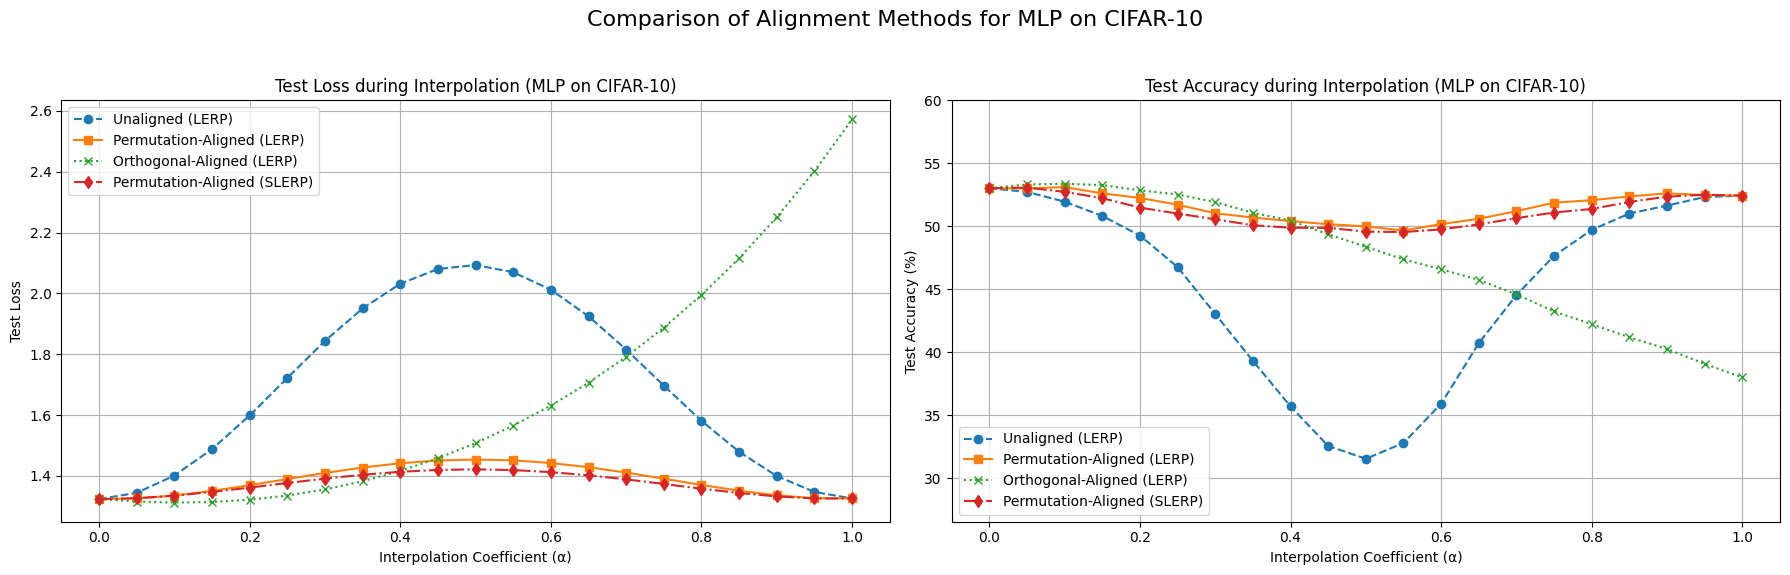

In [7]:
# --- ESPERIMENTO 3: MLP su CIFAR-10 ---

# Impostazioni Esperimento
DATASET_NAME_MLP_CIFAR = 'CIFAR10'
MODEL_ARCH_MLP_CIFAR = MLP_CIFAR # <-- MODIFICATO
EPOCHS_MLP_CIFAR = 20             # <-- 20 epoche dovrebbero bastare per un MLP
BATCH_SIZE_MLP_CIFAR = 128
SEED_A = 42
SEED_B = 123

# 1. Caricamento Dati
print(f"--- Caricando il dataset {DATASET_NAME_MLP_CIFAR} per l'MLP ---")
train_dataset_mc, test_dataset_mc, _ = get_datasets(DATASET_NAME_MLP_CIFAR)
train_loader_mc = DataLoader(train_dataset_mc, batch_size=BATCH_SIZE_MLP_CIFAR, shuffle=True)
test_loader_mc = DataLoader(test_dataset_mc, batch_size=BATCH_SIZE_MLP_CIFAR, shuffle=False)

# 2. Addestramento di Model A (MLP su CIFAR10)
print(f"\n--- Addestramento di Model A (MLP su CIFAR10, seed={SEED_A}) ---")
torch.manual_seed(SEED_A)
model_a_mc = MODEL_ARCH_MLP_CIFAR().to(DEVICE)
train_model(model_a_mc, train_loader_mc, DEVICE,  epochs=EPOCHS_MLP_CIFAR, weight_decay=1e-4) # Usiamo un po' di weight decay
sd_a_mc = model_a_mc.state_dict()
loss_a_mc, acc_a_mc = evaluate_model(model_a_mc, test_loader_mc, DEVICE)
print(f"Model A (MLP-CIFAR) - Test Loss: {loss_a_mc:.4f}, Test Accuracy: {acc_a_mc:.2f}%")

# 3. Addestramento di Model B (MLP su CIFAR10)
print(f"\n--- Addestramento di Model B (MLP su CIFAR10, seed={SEED_B}) ---")
torch.manual_seed(SEED_B)
model_b_mc = MODEL_ARCH_MLP_CIFAR().to(DEVICE)
train_model(model_b_mc, train_loader_mc, DEVICE, epochs=EPOCHS_MLP_CIFAR, weight_decay=1e-4)
sd_b_mc = model_b_mc.state_dict()
loss_b_mc, acc_b_mc = evaluate_model(model_b_mc, test_loader_mc, DEVICE)
print(f"Model B (MLP-CIFAR) - Test Loss: {loss_b_mc:.4f}, Test Accuracy: {acc_b_mc:.2f}%")

# 4. Esecuzione degli allineamenti
print("\n--- Esecuzione degli allineamenti per MLP su CIFAR10 ---")
permutation_aligner_mc = PermutationAligner(MODEL_ARCH_MLP_CIFAR)
aligned_sd_b_perm_mc = permutation_aligner_mc.align(sd_a_mc, sd_b_mc)

orthogonal_aligner_mc = OrthogonalAligner(MODEL_ARCH_MLP_CIFAR)
aligned_sd_b_orth_mc = orthogonal_aligner_mc.align(sd_a_mc, sd_b_mc)

# 5. Esecuzione delle interpolazioni
print("\n--- Esecuzione delle interpolazioni per MLP su CIFAR10 ---")
alphas_mc_naive, losses_mc_naive, accs_mc_naive = evaluate_interpolation(MODEL_ARCH_MLP_CIFAR, sd_a_mc, sd_b_mc, test_loader_mc, DEVICE)
alphas_mc_perm, losses_mc_perm, accs_mc_perm = evaluate_interpolation(MODEL_ARCH_MLP_CIFAR, sd_a_mc, aligned_sd_b_perm_mc, test_loader_mc, DEVICE)
alphas_mc_orth, losses_mc_orth, accs_mc_orth = evaluate_interpolation(MODEL_ARCH_MLP_CIFAR, sd_a_mc, aligned_sd_b_orth_mc, test_loader_mc, DEVICE)
alphas_mc_slerp, losses_mc_slerp, accs_mc_slerp = slerp_evaluate_interpolation(MODEL_ARCH_MLP_CIFAR, sd_a_mc, aligned_sd_b_perm_mc, test_loader_mc, DEVICE)

# 6. Generazione dei grafici
print("\n--- Generazione dei grafici per MLP su CIFAR10 ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(alphas_mc_naive, losses_mc_naive, marker='o', linestyle='--', label='Unaligned (LERP)')
ax1.plot(alphas_mc_perm, losses_mc_perm, marker='s', linestyle='-', label='Permutation-Aligned (LERP)')
ax1.plot(alphas_mc_orth, losses_mc_orth, marker='x', linestyle=':', label='Orthogonal-Aligned (LERP)')
ax1.plot(alphas_mc_slerp, losses_mc_slerp, marker='d', linestyle='-.', label='Permutation-Aligned (SLERP)')
ax1.set_title('Test Loss during Interpolation (MLP on CIFAR-10)')
ax1.set_xlabel('Interpolation Coefficient (α)')
ax1.set_ylabel('Test Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(alphas_mc_naive, accs_mc_naive, marker='o', linestyle='--', label='Unaligned (LERP)')
ax2.plot(alphas_mc_perm, accs_mc_perm, marker='s', linestyle='-', label='Permutation-Aligned (LERP)')
ax2.plot(alphas_mc_orth, accs_mc_orth, marker='x', linestyle=':', label='Orthogonal-Aligned (LERP)')
ax2.plot(alphas_mc_slerp, accs_mc_slerp, marker='d', linestyle='-.', label='Permutation-Aligned (SLERP)')
ax2.set_title('Test Accuracy during Interpolation (MLP on CIFAR-10)')
ax2.set_xlabel('Interpolation Coefficient (α)')
ax2.set_ylabel('Test Accuracy (%)')
ax2.grid(True)
min_acc = np.min(np.concatenate([accs_mc_naive, accs_mc_orth, accs_mc_perm])) if len(accs_mc_naive) > 0 else 10
ax2.set_ylim(bottom=max(0, min_acc - 5), top=60) # Adattiamo l'asse Y
ax2.legend()

plt.suptitle('Comparison of Alignment Methods for MLP on CIFAR-10', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()